In [1]:
import polars as pl
import polars.selectors as cs
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [36]:
sns.set_style('whitegrid')

In [2]:
tasks = pl.read_csv('../datasets/GlobusComputeDataset-v1-tasks.csv')

In [3]:
tasks = tasks.fill_nan(None).drop_nulls(subset=cs.numeric())

In [9]:
functions = pl.read_csv('../datasets/functions_collect.csv', separator=";", has_header=False, new_columns=['ID', 'cluster'])

In [5]:
tasks = (
    tasks
        .with_columns_seq(end_to_end=(pl.col("result_received") - pl.col("received")) / 1000000000)
        .with_columns_seq(
            pl
             .when(pl.col('end_to_end') < 30).then(pl.lit('LOW'))
             .when(pl.col('end_to_end') < 45).then(pl.lit('30'))
             .when(pl.col('end_to_end') < 80).then(pl.lit('45'))
             .otherwise(pl.lit('80'))
             .alias('latyp')
        )
)

In [14]:
tasks = tasks.select(
    pl.col('end_to_end'),
    pl.col('latyp'),
    pl.col('function_uuid')
).join(functions, left_on='function_uuid', right_on='ID')

In [17]:
tasks = tasks.filter(
    pl.col('cluster') != 'Trivial',
    pl.col('cluster') != 'Job Scheduling',
    pl.col('cluster') != 'Unclustered'
)

Text(0, 0.5, 'Percentage')

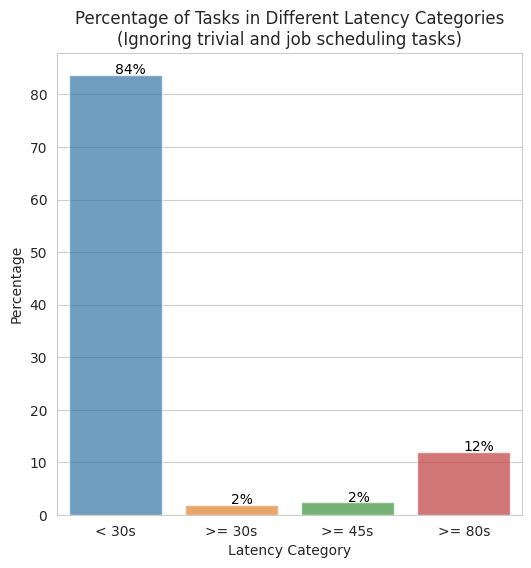

In [39]:
latencies = tasks['end_to_end']

compute_pct = lambda series, min, max: (series.filter((series >= min) & (series < max)).len() / series.len()) * 100

categories = pl.DataFrame({
    'pct': [
        compute_pct(latencies, 0, 30),
        compute_pct(latencies, 30, 45),
        compute_pct(latencies, 45, 80),
        compute_pct(latencies, 80, float('inf'))
    ], 
    'latcat': ['< 30s', '>= 30s', '>= 45s', '>= 80s']
})

plt.figure(figsize=(6, 6))

sns.barplot(categories, y='pct', x='latcat', hue='latcat', alpha=.7)

for index, row in enumerate(categories.iter_rows(named=True)):
    pct = row['pct']
    plt.text(index, pct+1, f'{pct:.0f}%', color='black', va="center")

plt.title('Percentage of Tasks in Different Latency Categories\n(Ignoring trivial and job scheduling tasks)')
plt.xlabel('Latency Category')
plt.ylabel('Percentage')